Basic framework for to explore the effects of white-box evasion attacks on the MNIST/CIFAR-10 datasets. Metrics and defences are also explored, the latter mainly involving image preprocessing (i.e. input transformations) and adversarial training.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import TotalVarMin, SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.metrics import empirical_robustness, clever_u
from art.data_generators import KerasDataGenerator
from art.utils import load_mnist, load_cifar10, get_file

Modification: Disabling eager execution to enable Section 1, Step 3

In [2]:
tf.compat.v1.disable_eager_execution()

Section 1 - Attacks

Step 1a: Load the MNIST dataset

In [3]:
#MNIST#ataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
#x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:100], y_test[:100]

Step 1b: Load the CIFAR-10 dataset

In [ ]:
# CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
# #x_train, y_train = x_train[:5000], y_train[:5000]
# x_test, y_test = x_test[:500], y_test[:500]

Step 2: Load/Create the classifier model 

In [4]:
#path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
#                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')

model = load_model("/home/cyber/basicmodel.h5")
#model = load_model(path)

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

In [ ]:
# model = Sequential()
# model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation="relu"))
# model.add(Dense(10, activation="softmax"))

# model.compile(
#     loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
# )

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
# model.add(Activation("relu"))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(10))
# model.add(Activation("softmax"))

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Optional step: Train and save the ART classifier for future use (use when exploring new models)

In [ ]:
#classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

In [ ]:
#classifier.save("/home/cyber/basicmodel.h5")

Step 3: Evaluate the ART classifier on benign test examples

In [13]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print("Undefended classifier")
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Undefended classifier
Accuracy on benign test examples: 14.000000000000002%


Step 4: Craft adversarial examples

In [6]:
#adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(classifier, eps=0.2)
adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv = adv_crafter.generate(x_test)


Step 5: Evaluate the ART classifier on the adversarial test set

In [7]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Undefended classifier")
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Undefended classifier
Accuracy on adversarial test examples: 23.0%


Optional step: Plot images and their adversarial counterparts for reference

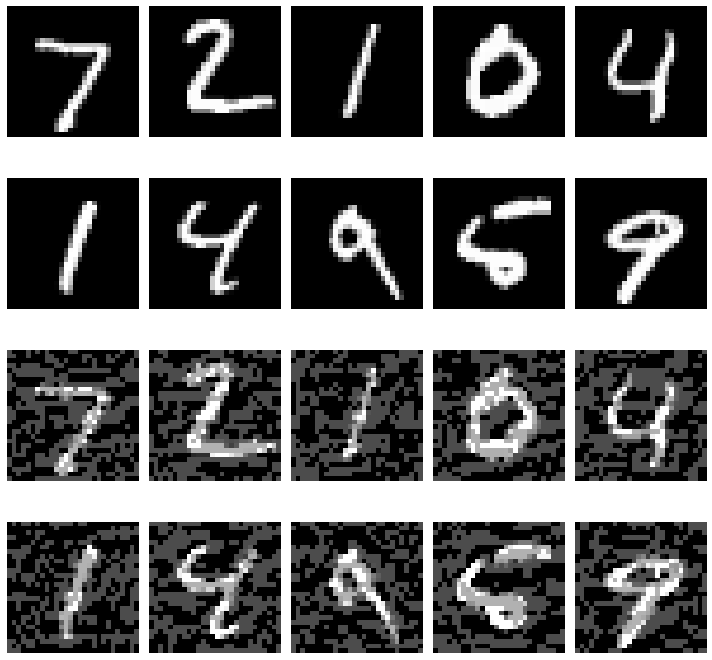

In [8]:
num = 10
images = x_test[:num]
adv_examples = x_test_adv[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(adv_examples[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
    
plt.tight_layout()
plt.show()

Section 2 - Metrics

Metric 1: Empirical Robustness

In [ ]:
attack_name = "fgsm"
score = empirical_robustness(classifier=classifier, x=x_test, attack_name=attack_name)
print("Empirical robustness of the classifier against {}: {}".format(attack_name, score))

Metric 2: CLEVER

In [ ]:
score = clever_u(classifier=classifier, x=x_test[1], nb_batches=10, batch_size=64, radius=25,norm=2)
print("CLEVER score of the classifier against an untargeted attack: {}".format(score))

Section 3 - Defence

Save original adversarial examples for reference

In [ ]:
x_test_adv_original = x_test_adv

Creating a seperate 'robust' classifier, to enable side-by-sde analysis of both the original and defended model

In [ ]:
robust_classifier = classifier

Defence 1: Preprocessing

Step 1: Input transformation

In [ ]:
#defence = TotalVarMin(verbose = True)
defence = SpatialSmoothing(window_size=5)

x_test_adv = defence(x_test_adv_original * 255)[0] / 255

#what does * 255)[0] / 255 do?

Additional step: Plot images and their transformed adversarial counterparts for reference

In [ ]:
num = 10
transformed_adv_examples = x_test_adv[:num]
pretransformed_adv_examples = x_test_adv_original[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(6, 5, i + 11)
    plt.imshow(pretransformed_adv_examples[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(6, 5, i + 21)
    plt.imshow(transformed_adv_examples[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
    
plt.tight_layout()
plt.show()

Defence 2: Adversarial Training

Adversarial Training: Method 1 - Data Generators

Step 1: Build a Keras image augmentation object and wrap it in ART

In [9]:
batch_size = 50

datagen = ImageDataGenerator(
    horizontal_flip=True, width_shift_range=0.125, height_shift_range=0.125, fill_mode="constant", cval=0.0
)
datagen.fit(x_train)
art_datagen = KerasDataGenerator(
    datagen.flow(x=x_train, y=y_train, batch_size=batch_size, shuffle=True),
    size=x_train.shape[0],
    batch_size=batch_size,
)

Step 2: Create adversarial trainer

In [10]:
adv_trainer = AdversarialTrainer(classifier, attacks=adv_crafter, ratio=1.0)

Step 3: Perform adversarial training

In [11]:
adv_trainer.fit_generator(art_datagen, nb_epochs=5)

Precompute adversarial examples.:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Adversarial Training: Alternative method

In [ ]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_pixel_value, max_pixel_value), model=robust_classifier_model, use_logits=False)

Defence: Evaluation of effectiveness

Step 1: Evaluate the defended model on the clean test set

In [12]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Defended classifier
Accuracy on benign test examples: 14.000000000000002%


Step 2: Evaluate the defended model on the original adversarial test set

In [ ]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on original adversarial test examples: {}%".format(accuracy * 100))

Step 3: Evaluate the defended model on new adversarial examples produced on the defended model

In [ ]:
#adv_crafter = SaliencyMapMethod(classifier=robust_classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(robust_classifier, eps=0.2)
adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=robust_classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=robust_classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=robust_classifier, verbose=True)

x_test_adv = adv_crafter.generate(x_test)

#The following line is for when a preprocessing defence is used
#x_test_adv = defence(x_test_adv * 255)[0] / 255

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on new adversarial test examples: {}%".format(accuracy * 100))

Step 4: Compare the performance of the original and the robust classifier against FGSM over a range of eps values

In [ ]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy_original = []
accuracy_robust = []

adv_crafter = FastGradientMethod(robust_classifier)
adv_crafter_robust = FastGradientMethod(robust_classifier)

for eps in eps_range:
    adv_crafter.set_params(**{'eps': eps})
    adv_crafter_robust.set_params(**{'eps': eps})
    x_test_adv = adv_crafter.generate(x_test[:100])
    x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
    predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
    accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
    predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
accuracy_original = [accuracy_pred] + accuracy_original
accuracy_robust = [accuracy_robust_pred] + accuracy_robust
#what is accuracy_pred and accuracy_robust_pred

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()